# Analysis of SIF and XCO2

Resolution: hemisphere, monthly

---

In [1]:
import numpy as np
import pandas as pd
import xarray

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Open and split datasets by hemisphere
with xarray.open_mfdataset("../data/exp_pro/OCO2_Lite_SIF740.nc", parallel=True) as DS:
    DS_sif_north = DS.where(DS.lat >= 0, drop=True)
    DS_sif_south = DS.where(DS.lat < 0, drop=True)

with xarray.open_mfdataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc", parallel=True) as DS:
    DS_xco2_north = DS.where(DS.lat >= 0, drop=True)
    DS_xco2_south = DS.where(DS.lat < 0, drop=True)

## Northern hemisphere

In [6]:
# Compute monthly climatologies
df_sif_n_monthly = DS_sif_north.sif.resample(time="1MS").mean(dim="time").to_dataframe()
df_xco2_n_monthly = DS_xco2_north.xco2.resample(time="1MS").mean(dim="time").to_dataframe()
df_n_monthly = pd.merge(df_sif_n_monthly, df_xco2_n_monthly, how="outer", on=["time"]).reset_index()

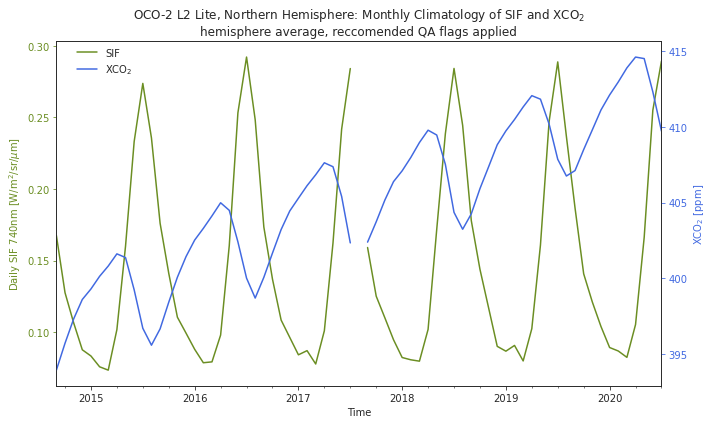

In [29]:
# Plot global monthly climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_n_monthly.plot(x="time", y="sif", color=sif_color, ax=ax1, legend=False, label="SIF")
df_n_monthly.plot(x="time", y="xco2", color=xco2_color, ax=ax2, legend=False, label="XCO$_2$")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite, Northern Hemisphere: Monthly Climatology of SIF and XCO$_2$\n"
              "hemisphere average, reccomended QA flags applied")

plt.tight_layout()
plt.savefig("../plots/monthly_climatology_north.png")

In [31]:
## Create a dataframe of SIF residuals and XCO2 residuals lagged by 0-4 months

# Interpolate missing values
df_n_monthly_interp = df_n_monthly.interpolate().set_index("time")

# Fit trends by least squares
X = (df_n_monthly_interp.index - df_n_monthly_interp.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_n_monthly_interp.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_n_monthly_interp.xco2).predict(X)

# Remove trends
df_n_monthly_interp["sif_anom_lag0"] = df_n_monthly_interp.sif - trend_sif
df_n_monthly_interp["xco2_anom"] = df_n_monthly_interp.xco2 - trend_xco2


# Apply monthly lag
for t in range(1, 5):
    df_n_monthly_interp[f"sif_anom_lag{t}"] = df_n_monthly_interp.sif_anom_lag0.shift(t)

    
df_n_monthly_interp

,sif,xco2,sif_anom_lag0,xco2_anom,sif_anom_lag1,sif_anom_lag2,sif_anom_lag3,sif_anom_lag4
time,,,,,,,,
2014-09-01,0.167573,393.916931,0.031823,-3.525456,NaN,NaN,NaN,NaN
2014-10-01,0.127645,395.695984,-0.008467,-1.961004,0.031823,NaN,NaN,NaN
2014-11-01,0.106573,397.305817,-0.029913,-0.572924,-0.008467,0.031823,NaN,NaN
2014-12-01,0.087775,398.590240,-0.049074,0.496899,-0.029913,-0.008467,0.031823,NaN
2015-01-01,0.083435,399.285278,-0.053789,0.970184,-0.049074,-0.029913,-0.008467,0.031823
...,...,...,...,...,...,...,...,...
2020-03-01,0.082491,413.904877,-0.077522,2.098589,-0.072728,-0.069931,-0.054868,-0.037403
2020-04-01,0.105391,414.620880,-0.054997,2.592839,-0.077522,-0.072728,-0.069931,-0.054868
2020-05-01,0.166247,414.519501,0.005497,2.276860,-0.054997,-0.077522,-0.072728,-0.069931


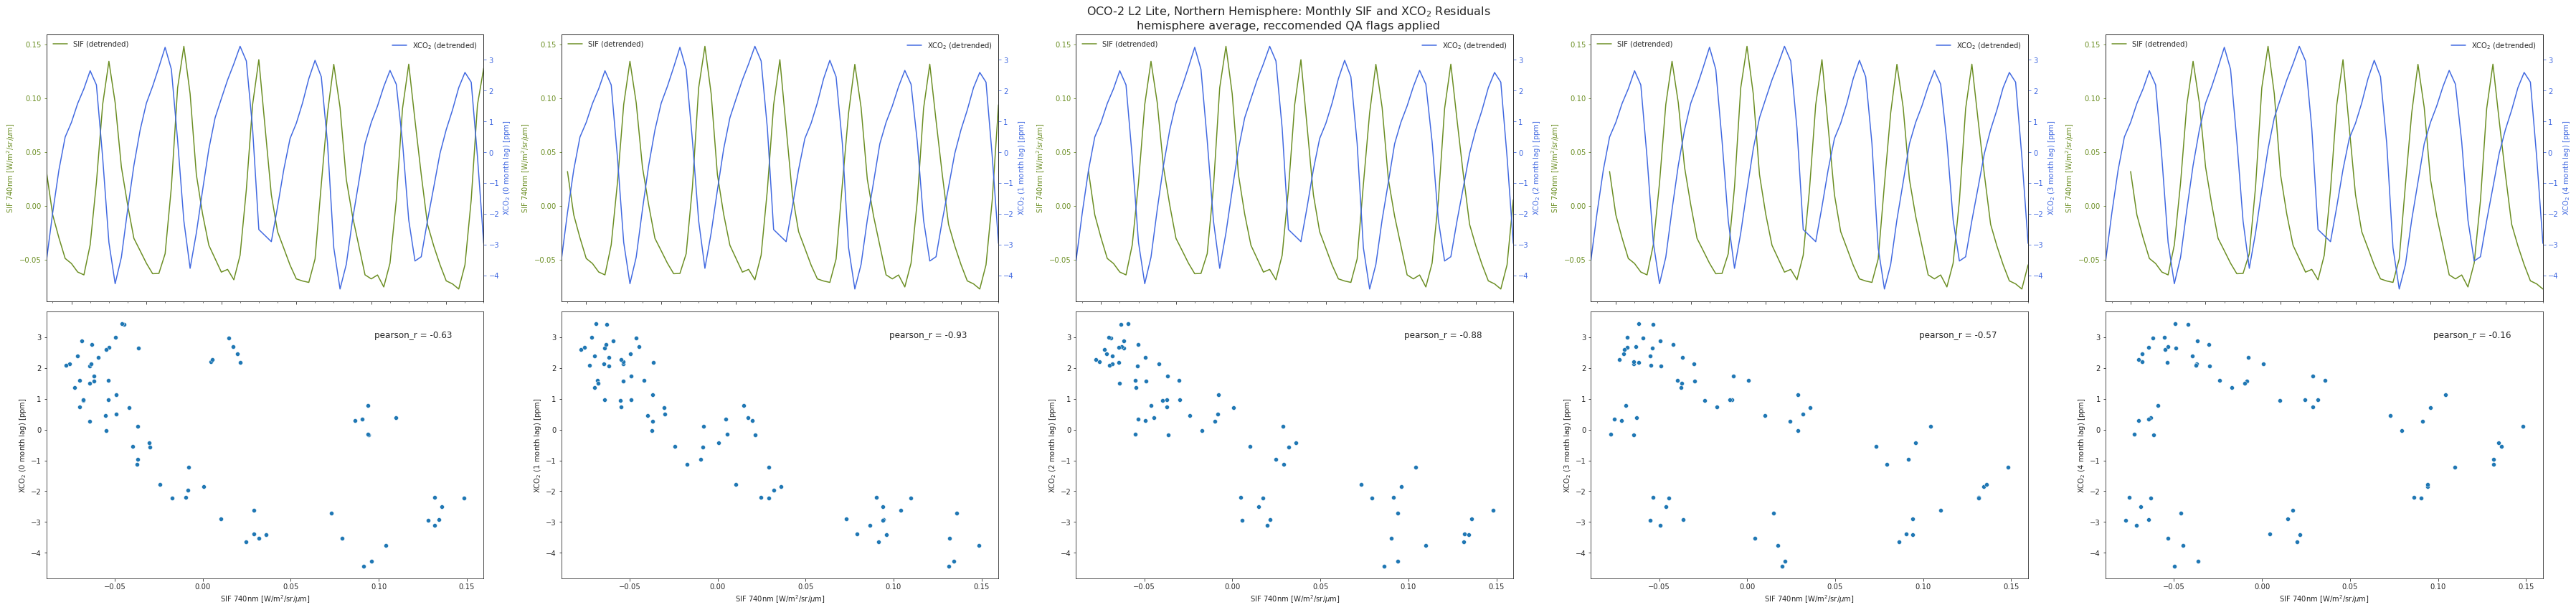

In [32]:
## Create grid of figures with timeseries on top row and scatter plots on bottom
fig, axes = plt.subplots(2, 5, figsize=(50, 12))
fig.subplots_adjust(top=0.85)
fig.suptitle("OCO-2 L2 Lite, Northern Hemisphere: Monthly SIF and XCO$_2$ Residuals\n"
             "hemisphere average, reccomended QA flags applied",
             size=16)

sif_color = "olivedrab"
xco2_color = "royalblue"

# Time series
for j in range(5):
    ax1 = axes[0, j]
    ax2 = ax1.twinx()
    
    df_n_monthly_interp.plot(y=f"sif_anom_lag{j}", use_index=True, color=sif_color, ax=ax1, legend=False, label="SIF (detrended)")
    df_n_monthly_interp.plot(y="xco2_anom", use_index=True, color=xco2_color, ax=ax2, legend=False, label="XCO$_2$ (detrended)")

    # Customize axes
    ax1.tick_params(axis="y", colors=sif_color)
    ax2.tick_params(axis="y", colors=xco2_color)
    ax1.yaxis.label.set_color(sif_color)
    ax2.yaxis.label.set_color(xco2_color)
    ax1.legend(loc="upper left", frameon=False)
    ax2.legend(loc="upper right", frameon=False)

    # Add titles
    ax1.set_xlabel("Time")
    ax1.set_ylabel("SIF 740nm [W/m$^2$/sr/$\mu$m]")
    ax2.set_ylabel(f"XCO$_2$ ({j} month lag) [ppm]")
    
    
# Scatterplots
for j in range(5):
    pearson_corr = df_n_monthly_interp.xco2_anom.corr(df_n_monthly_interp[f"sif_anom_lag{j}"])
    sns.scatterplot(x=f"sif_anom_lag{j}", y="xco2_anom", data=df_n_monthly_interp, ax=axes[1, j])
    axes[1, j].annotate("pearson_r = {:.2f}".format(pearson_corr), fontsize=12,
                        xy=(0.1, 0.9), xytext=(0.75, 0.9), textcoords="axes fraction")
    axes[1, j].set_xlabel("SIF 740nm [W/m$^2$/sr/$\mu$m]")
    axes[1, j].set_ylabel(f"XCO$_2$ ({j} month lag) [ppm]")


plt.tight_layout()
plt.savefig("../plots/monthly_lagged_residual_analysis_north.png")

## Southern hemisphere

In [19]:
# Compute monthly climatologies
df_sif_s_monthly = DS_sif_south.sif.resample(time="1MS").mean(dim="time").to_dataframe()
df_xco2_s_monthly = DS_xco2_south.xco2.resample(time="1MS").mean(dim="time").to_dataframe()
df_s_monthly = pd.merge(df_sif_s_monthly, df_xco2_s_monthly, how="outer", on=["time"]).reset_index()

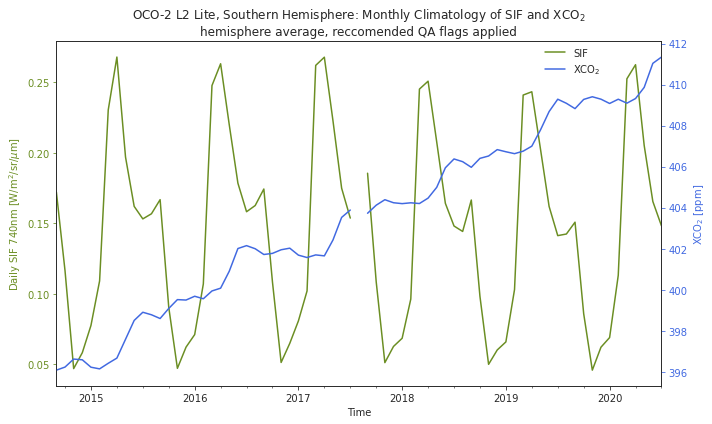

In [33]:
# Plot global monthly climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_s_monthly.plot(x="time", y="sif", color=sif_color, ax=ax1, legend=False, label="SIF")
df_s_monthly.plot(x="time", y="xco2", color=xco2_color, ax=ax2, legend=False, label="XCO$_2$")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.75, 0.9), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite, Southern Hemisphere: Monthly Climatology of SIF and XCO$_2$\n"
              "hemisphere average, reccomended QA flags applied")

plt.tight_layout()
plt.savefig("../plots/monthly_climatology_south.png")

In [34]:
## Create a dataframe of SIF residuals and XCO2 residuals lagged by 0-4 months

# Interpolate missing values
df_s_monthly_interp = df_s_monthly.interpolate().set_index("time")

# Fit trends by least squares
X = (df_s_monthly_interp.index - df_s_monthly_interp.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_s_monthly_interp.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_s_monthly_interp.xco2).predict(X)

# Remove trends
df_s_monthly_interp["sif_anom_lag0"] = df_s_monthly_interp.sif - trend_sif
df_s_monthly_interp["xco2_anom"] = df_s_monthly_interp.xco2 - trend_xco2


# Apply monthly lag
for t in range(1, 5):
    df_s_monthly_interp[f"sif_anom_lag{t}"] = df_s_monthly_interp.sif_anom_lag0.shift(t)

    
df_s_monthly_interp

,sif,xco2,sif_anom_lag0,xco2_anom,sif_anom_lag1,sif_anom_lag2,sif_anom_lag3,sif_anom_lag4
time,,,,,,,,
2014-09-01,0.172178,396.080261,0.031385,-0.103597,NaN,NaN,NaN,NaN
2014-10-01,0.116398,396.229889,-0.024525,-0.159133,0.031385,NaN,NaN,NaN
2014-11-01,0.046893,396.619873,-0.094165,0.018849,-0.024525,0.031385,NaN,NaN
2014-12-01,0.058187,396.584564,-0.083002,-0.221623,-0.094165,-0.024525,0.031385,NaN
2015-01-01,0.077500,396.223938,-0.063825,-0.794251,-0.083002,-0.094165,-0.024525,0.031385
...,...,...,...,...,...,...,...,...
2020-03-01,0.252618,409.094604,0.103068,-0.821509,-0.036319,-0.080356,-0.087068,-0.103223
2020-04-01,0.262612,409.321259,0.112927,-0.806857,0.103068,-0.036319,-0.080356,-0.087068
2020-05-01,0.205295,409.864410,0.055479,-0.468868,0.112927,0.103068,-0.036319,-0.080356


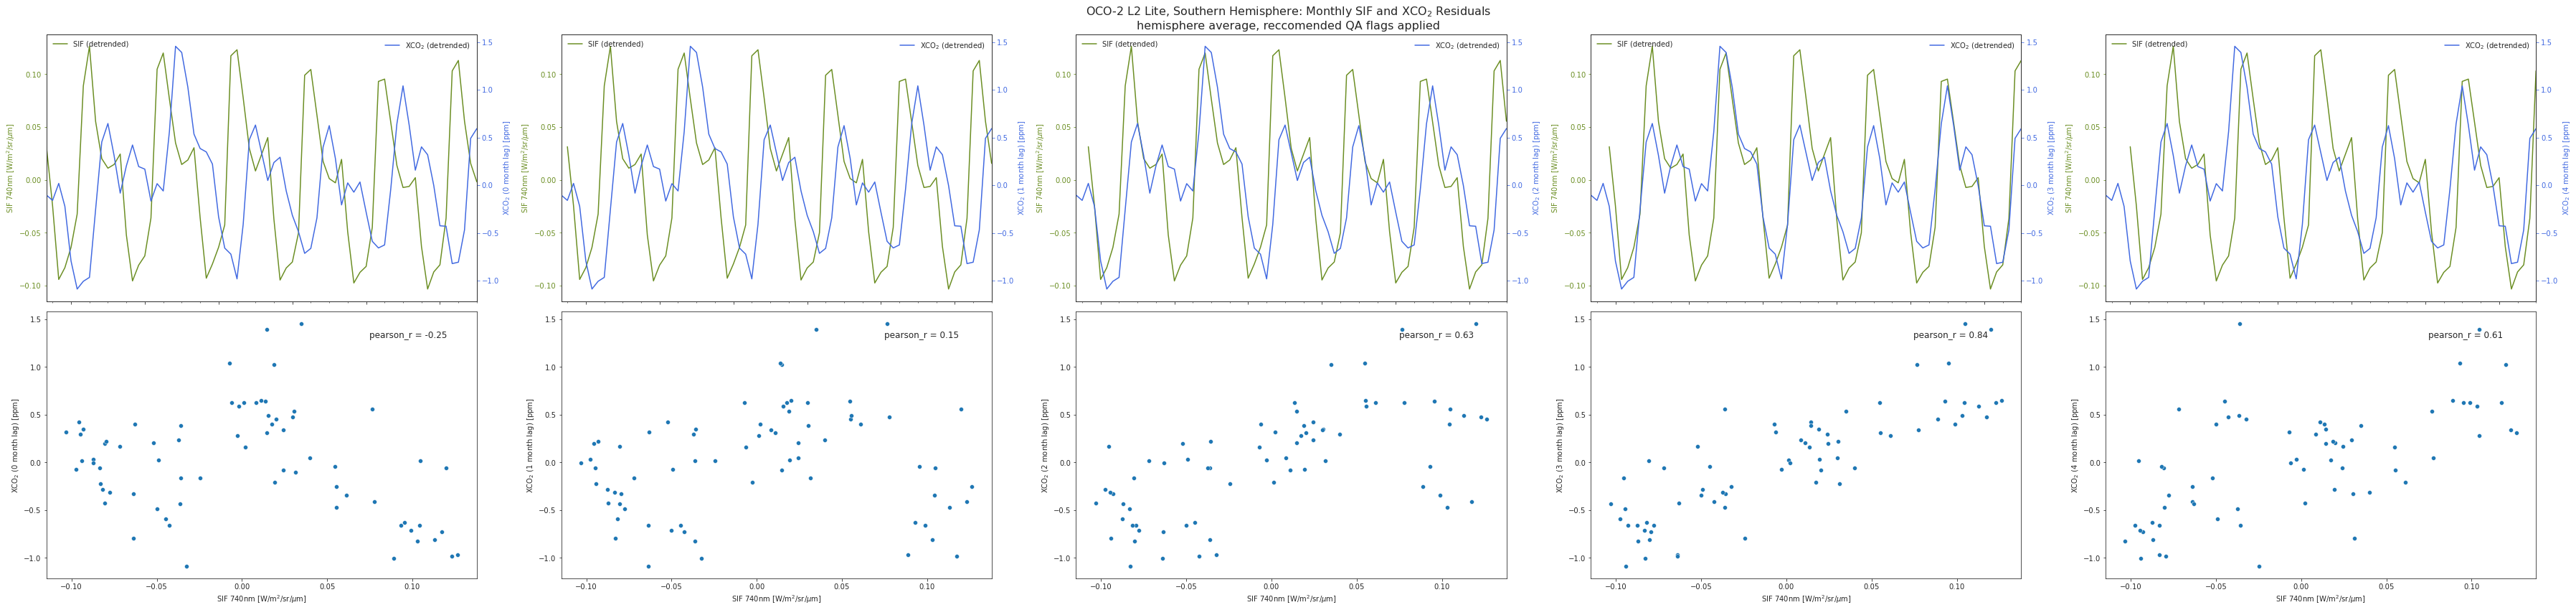

In [35]:
## Create grid of figures with timeseries on top row and scatter plots on bottom
fig, axes = plt.subplots(2, 5, figsize=(50, 12))
fig.subplots_adjust(top=0.85)
fig.suptitle("OCO-2 L2 Lite, Southern Hemisphere: Monthly SIF and XCO$_2$ Residuals\n"
             "hemisphere average, reccomended QA flags applied",
             size=16)

sif_color = "olivedrab"
xco2_color = "royalblue"

# Time series
for j in range(5):
    ax1 = axes[0, j]
    ax2 = ax1.twinx()
    
    df_s_monthly_interp.plot(y=f"sif_anom_lag{j}", use_index=True, color=sif_color, ax=ax1, legend=False, label="SIF (detrended)")
    df_s_monthly_interp.plot(y="xco2_anom", use_index=True, color=xco2_color, ax=ax2, legend=False, label="XCO$_2$ (detrended)")

    # Customize axes
    ax1.tick_params(axis="y", colors=sif_color)
    ax2.tick_params(axis="y", colors=xco2_color)
    ax1.yaxis.label.set_color(sif_color)
    ax2.yaxis.label.set_color(xco2_color)
    ax1.legend(loc="upper left", frameon=False)
    ax2.legend(loc="upper right", frameon=False)

    # Add titles
    ax1.set_xlabel("Time")
    ax1.set_ylabel("SIF 740nm [W/m$^2$/sr/$\mu$m]")
    ax2.set_ylabel(f"XCO$_2$ ({j} month lag) [ppm]")
    
    
# Scatterplots
for j in range(5):
    pearson_corr = df_s_monthly_interp.xco2_anom.corr(df_s_monthly_interp[f"sif_anom_lag{j}"])
    sns.scatterplot(x=f"sif_anom_lag{j}", y="xco2_anom", data=df_s_monthly_interp, ax=axes[1, j])
    axes[1, j].annotate("pearson_r = {:.2f}".format(pearson_corr), fontsize=12,
                        xy=(0.1, 0.9), xytext=(0.75, 0.9), textcoords="axes fraction")
    axes[1, j].set_xlabel("SIF 740nm [W/m$^2$/sr/$\mu$m]")
    axes[1, j].set_ylabel(f"XCO$_2$ ({j} month lag) [ppm]")


plt.tight_layout()
plt.savefig("../plots/monthly_lagged_residual_analysis_south.png")